In [89]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import c

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import t as t 

from uncertainties import *
from uncertainties.unumpy import *
from uncertainties.umath import *

In [90]:
# Plot settings
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

In [91]:
# Constants and values 
c_ms = c.value

lab_lines_list = []
lab_line_err = []
with open('data/final.dline26', 'r') as f:
    for line in f:
        if line.strip():  
            parts = line.split()
            lab_lines_list.append(float(parts[1]))  
            lab_line_err.append(float(parts[2]))
lab_lines = []
for i in range(16, 33):
    # print(i)
    if i in [20,26,30,32]:
        continue
    lab_lines.append(lab_lines_list[i])

print(len(lab_lines))

lab_lines_min = np.min(lab_lines)
lab_lines_max = np.max(lab_lines)

lab_lines_df = pd.DataFrame({
    'Line': lab_lines,
    'Error': lab_line_err[:len(lab_lines)] 
})

lab_lines_df.to_csv('data/lab_lines.csv', index=False)

13


In [97]:
print(lab_lines_min, lab_lines_max)

6872.251067289 6888.950940989


In [92]:
# Importing the data
fits_files = ["FVSco-04_44.fits", "FVSco-209_06.fits", "HD64740_010r_26.wl.fits"] 

In [93]:
# Functions
def normalize_spectrum(wavelength, flux):
    return wavelength, flux / np.max(flux)

def calculate_rv(observed_wavelength, lab_wavelength):
    return c_ms * (observed_wavelength - lab_wavelength) / lab_wavelength

def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

Step for FVSco-04_44.fits: 0.1294


Step for FVSco-209_06.fits: 0.0621
Step for HD64740_010r_26.wl.fits: 0.0188

 FVSco-04_44.fits:
  Mean Measured RV: -23620.6831+/-246.1015 m/s
  Header RV: -24.83 m/s
  Difference: -23595.85+/-246.10 m/s

 FVSco-209_06.fits:
  Mean Measured RV: 46.2185+/-121.8935 m/s
  Header RV: 28.35 m/s
  Difference: 17.87+/-121.89 m/s

 HD64740_010r_26.wl.fits:
  Mean Measured RV: -1.8060+/-90.9256 m/s
  Header RV: -99999.00 m/s
  Difference: 99997.19+/-90.93 m/s


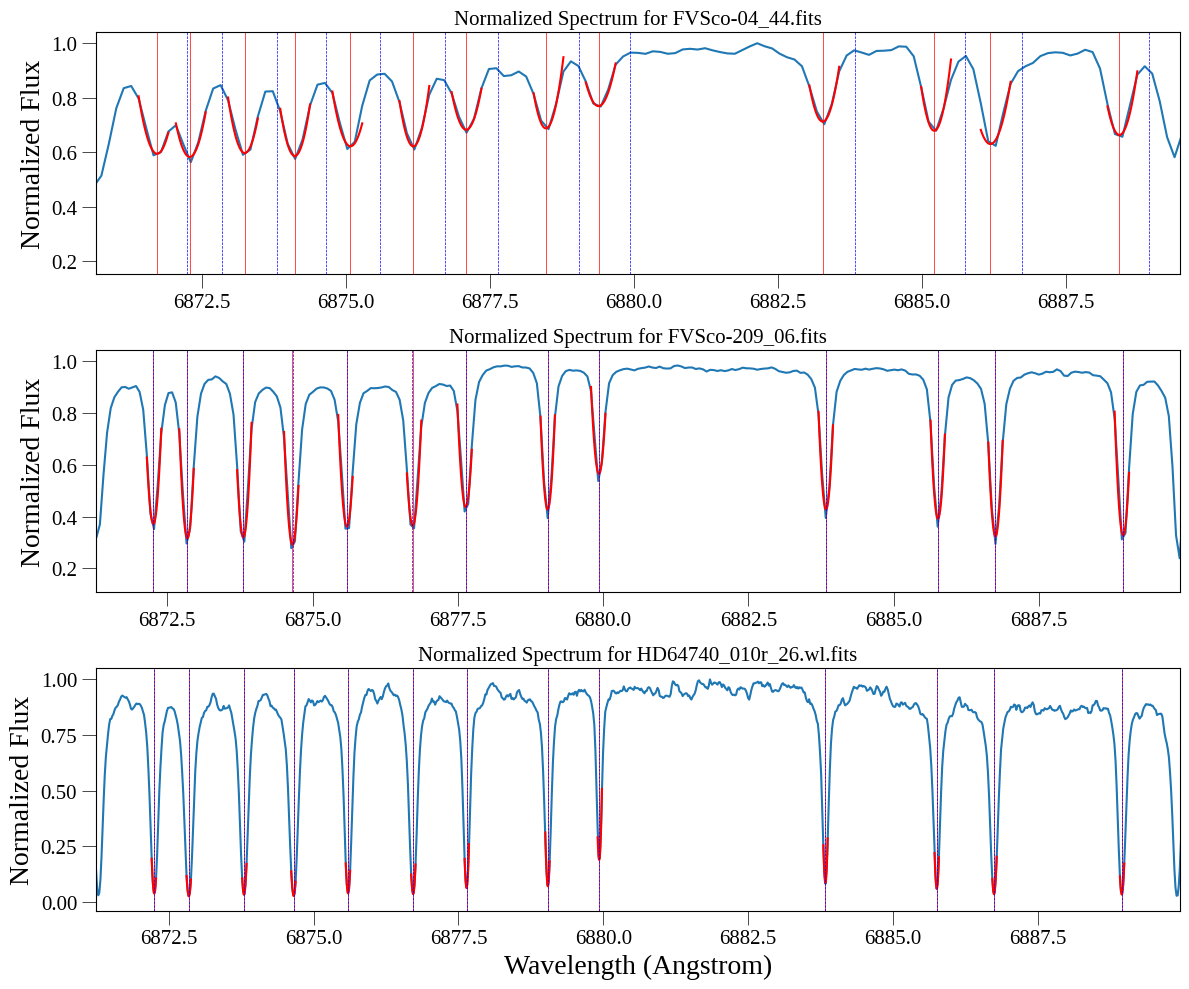

In [94]:
plt.figure(figsize=(12, 10))

header_rvs = []
mean_rvs = []
rv_vals = [[] for _ in range(len(fits_files))]
rv_errs = [[] for _ in range(len(fits_files))]
for i, fits_file in enumerate(fits_files):
    with fits.open(f'data/{fits_file}') as hdul:
        header = hdul[0].header
        flux = hdul[0].data

        # Finring RV from heared
        rv_helio = header.get('VHELIO', None)
        rv_hierarch = header.get('HIERARCH ESO TEL TARG RADVEL', None)
        if rv_helio is not None:
            header_rvs.append(rv_helio)
        elif rv_hierarch is not None:
            header_rvs.append(rv_hierarch)
        else:
            header_rvs.append(None)  

        # Creating wavelength array
        start_wavelength = header.get('CRVAL1', 0)  
        step = header.get('CDELT1', 1) 
        num_points = len(flux)
        wavelength = start_wavelength + step * np.arange(num_points)

        # Taking wavelength step as error
        print(f"Step for {fits_file}: {step:.4f}")

        # Doing normalization
        norm_wavelength, norm_flux = normalize_spectrum(wavelength, flux)

        # Local minima
        inverted_flux = -norm_flux
        minima_indices, _ = find_peaks(inverted_flux, prominence=0.1)
        minima_wavelengths = norm_wavelength[minima_indices]

        x = 0.8
        y= 0.2
        minima_wavelengths = minima_wavelengths[(minima_wavelengths > lab_lines_min-x) & (minima_wavelengths < lab_lines_max+y)]
        
        # Plot the spectra
        ax = plt.subplot(len(fits_files), 1, i + 1)
        ax.plot(norm_wavelength, norm_flux)
        
        # Find telluric lines
        rv_spectrum = []
        observed_wavelength_list = []

        min_positions = []
        errors = []

        counter = 0
        for lab_line in lab_lines:
            # Fitting the closest wavelength
            observed_wavelength = minima_wavelengths[counter]

            mask = (norm_wavelength >= observed_wavelength - step*2) & (norm_wavelength <= observed_wavelength + step*2)
            x_data = norm_wavelength[mask]
            y_data = norm_flux[mask]
            
            coeffs = np.polyfit(x_data, y_data, 2) 

            # Determine the minimum point of the quadratic fit
            # For y = ax^2 + bx + c, the minimum x is at -b / (2a)
            a, b, c = coeffs
            x_min = -b / (2 * a)
            y_min = np.polyval(coeffs, x_min)
            min_positions.append((x_min, y_min))

            ax.axvline(x_min, color='r', linewidth=0.5)

            # Estimate the error in x_min 
            residuals = y_data - np.polyval(coeffs, x_data)
            sigma_y = np.std(residuals) 
            sigma_x = sigma_y / abs(2 * a)  
            errors.append(sigma_x)

            # Generate the fitted curve 
            fit_x = np.linspace(observed_wavelength - step*2, observed_wavelength + step*2, 100)
            fit_y = np.polyval(coeffs, fit_x)
            plt.plot(fit_x, fit_y, color='red')

            rv = calculate_rv(ufloat(x_min, sigma_x), ufloat(lab_line, lab_line_err[counter]))
            rv_spectrum.append(rv)

            ax.axvline(lab_line, color='b', linewidth=0.5, linestyle='--')
            
            observed_wavelength_list.append(observed_wavelength)
            counter += 1

        # mean_rv = sum(rv_spectrum) / len(rv_spectrum)
        # mean_rvs.append(mean_rv)

        rv_spectrum_val = [x.n for x in rv_spectrum]
        rv_spectrum_err = [x.s for x in rv_spectrum]
        rv_vals[i] = rv_spectrum_val
        rv_errs[i] = rv_spectrum_err
        
        mean_rvs.append(ufloat(np.mean(rv_spectrum_val), uncert(rv_spectrum_val, np.mean(rv_spectrum_err))))
        
        if i == len(fits_files) - 1: 
            ax.set_xlabel('Wavelength (Angstrom)')
        ax.set_ylabel(r'Normalized Flux')
        ax.xaxis.label.set_fontsize(20)
        ax.yaxis.label.set_fontsize(20)
        ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
        ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
        ax.set_title(f'Normalized Spectrum for {fits_file}', fontsize=15)

        ax.set_xlim(min(observed_wavelength_list)-1, max(observed_wavelength_list)+1)
        # ax.set_xlim(6874,6876)

for i, fits_file in enumerate(fits_files):
    print(f"\n {fits_file}:")
    print(f"  Mean Measured RV: {mean_rvs[i]:.4f} m/s")
    print(f"  Header RV: {header_rvs[i]:.2f} m/s")
    print(f"  Difference: {mean_rvs[i] - header_rvs[i]:.2f} m/s")
plt.tight_layout()
# plt.savefig('images/spectra.png')
plt.show()

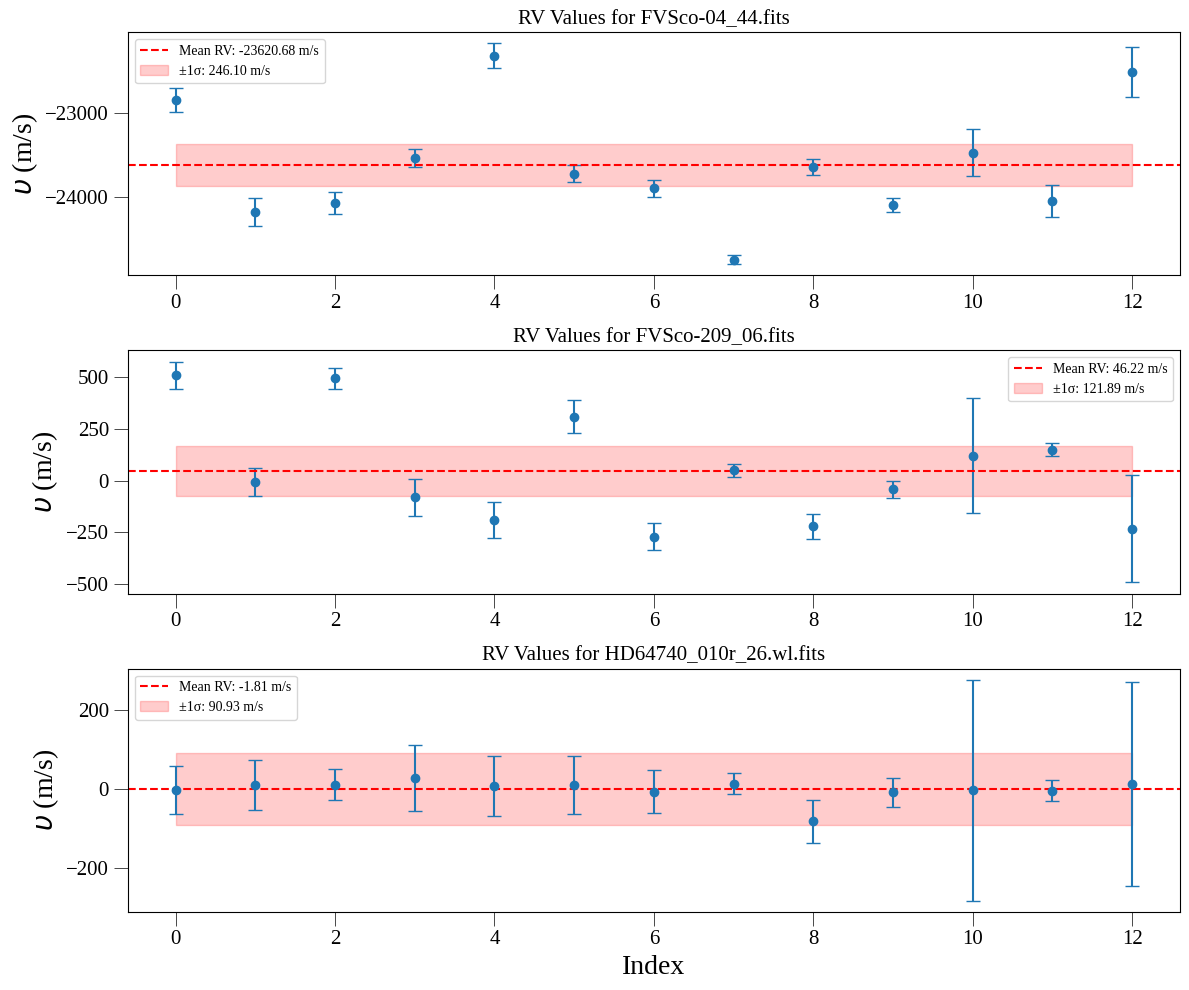

In [95]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

for i in range(3):
    x_values = list(range(len(rv_vals[i])))
    y_values = rv_vals[i]
    y_errors = rv_errs[i]

    mean_rv_value = mean_rvs[i].n
    mean_rv_error = mean_rvs[i].s

    if i == len(fits_files) - 1: 
        axs[i].set_xlabel('Index')
    
    axs[i].set_ylabel(r'$\upsilon$ (m/s)')

    axs[i].xaxis.label.set_fontsize(20)
    axs[i].yaxis.label.set_fontsize(20)

    axs[i].set_title(f'RV Values for {fits_files[i]}', fontsize=15)
    axs[i].tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    axs[i].tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    
    axs[i].errorbar(x_values, y_values, yerr=y_errors, fmt='o', capsize=5)

    axs[i].axhline(y=mean_rv_value, color='r', linestyle='--', label=f'Mean RV: {mean_rv_value:.2f} m/s')
    axs[i].fill_between(x_values, mean_rv_value - mean_rv_error, mean_rv_value + mean_rv_error, color='r', alpha=0.2, label=f'±1σ: {mean_rv_error:.2f} m/s')

    axs[i].legend()
plt.tight_layout()
plt.show()
fig.savefig('images/rv_values.png')